# Naive Bayes
Load the 20 newsgroups data and observe the learning rate with a naive bayes classifier. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [4]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

## Helper functions

In [5]:
class LemmaTokenizer(object):
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

## Explore the dataset

In [6]:
newsgroups_train = fetch_20newsgroups(subset='train')

In [7]:
category_map = dict(zip(range(20),
                        newsgroups_train.target_names))

In [8]:
data_categories = pd.Series(map(category_map.get, 
                            newsgroups_train.target.tolist()))

In [9]:
data_categories.value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
sci.space                   593
comp.windows.x              593
sci.electronics             591
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
dtype: int64

#### Test data statistics

In [10]:
newsgroups_test = fetch_20newsgroups(subset='test')

In [11]:
data_categories = pd.Series(map(category_map.get, 
                            newsgroups_test.target.tolist()))

In [12]:
data_categories.value_counts()

rec.sport.hockey            399
soc.religion.christian      398
rec.motorcycles             398
rec.sport.baseball          397
sci.crypt                   396
rec.autos                   396
sci.med                     396
comp.windows.x              395
comp.os.ms-windows.misc     394
sci.space                   394
sci.electronics             393
comp.sys.ibm.pc.hardware    392
misc.forsale                390
comp.graphics               389
comp.sys.mac.hardware       385
talk.politics.mideast       376
talk.politics.guns          364
alt.atheism                 319
talk.politics.misc          310
talk.religion.misc          251
dtype: int64

## Build the data set by tokenizing and lemmetizing

In [13]:
categories = ['rec.motorcycles', 'rec.autos']

In [14]:
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories)

In [15]:
newsgroups_test = fetch_20newsgroups(subset='test',
                                      categories=categories)

## First model

In [16]:
vec = TfidfVectorizer(stop_words='english',
                      tokenizer = LemmaTokenizer())

In [17]:
vectors = vec.fit_transform(newsgroups_train.data)

In [18]:
vectors.shape

(1192, 19829)

In [19]:
clf = MultinomialNB(alpha=1)

In [20]:
clf.fit(vectors, newsgroups_train.target)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [21]:
vectors_test = vec.transform(newsgroups_test.data)

In [22]:
pred = clf.predict(vectors_test)

In [23]:
metrics.f1_score(newsgroups_test.target, pred, average='macro')

0.9710315968471361

In [24]:
metrics.accuracy_score(newsgroups_test.target, pred)

0.9710327455919395

## Learning curve

In [25]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [26]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.ylim(ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X, 
                                                            y, 
                                                            cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

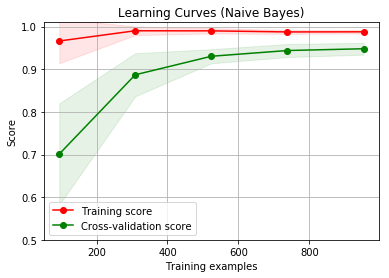

In [27]:
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
X, y = vectors, newsgroups_train.target
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.savefig('../docs/nb_learning_curve.png')
plt.show()

In [28]:
len(newsgroups_test.data)

794

In [29]:
X.shape

(1192, 19829)

## Raise the number of df to improve generality

In [30]:
word_counts = np.array([1000, 2000, 10000, 20000, 118548])
word_counts = [int(x) for x in word_counts]

In [31]:
from sklearn.model_selection import StratifiedKFold

In [32]:
def vocab_learning_curve(word_counts, model, lemmatizer, dataset, n_splits):
    kf = StratifiedKFold(n_splits=n_splits)
    test_scores = np.zeros((len(word_counts), n_splits))
    train_scores = np.zeros((len(word_counts), n_splits))
    for tick_idx, word_count in enumerate(word_counts):
        vec = TfidfVectorizer(stop_words='english',
                      tokenizer = lemmatizer,
                      max_features = word_count)
        vectors = vec.fit_transform(newsgroups_train.data)
        fold_idx = 0
        for train_index, test_index in kf.split(vectors, dataset.target):
            x_train, x_test = vectors[train_index], vectors[test_index]
            y_train, y_test = dataset.target[train_index], dataset.target[test_index]
            
            model.fit(x_train, y_train)
            test_scores[tick_idx][fold_idx] = metrics.accuracy_score(y_test, 
                                                                      model.predict(x_test))
            train_scores[tick_idx][fold_idx] = metrics.accuracy_score(y_train, 
                                                              model.predict(x_train))
            print(word_count)
            fold_idx += 1
    return  word_counts, np.array(train_scores), np.array(test_scores)


In [33]:
train_sizes, train_scores, test_scores = vocab_learning_curve(word_counts, clf, LemmaTokenizer(), newsgroups_train, 4)

1000
1000
1000
1000
2000
2000
2000
2000
10000
10000
10000
10000
20000
20000
20000
20000
118548
118548
118548
118548


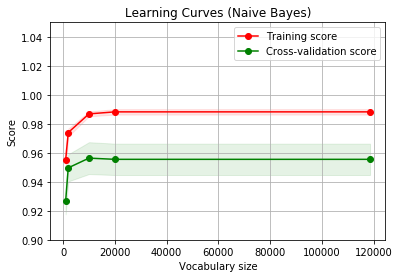

In [34]:
plt.figure()
plt.title(title)
plt.ylim((0.9, 1.05))
plt.xlabel('Vocabulary size')
plt.ylabel('Score')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.savefig('../docs/nb_vocab_size.png')
plt.show()

## SVM

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

In [36]:
svm_clf = SVC(C=1, kernel='rbf', gamma='auto', shrinking=True,
              tol=1e-3, probability=False)

In [37]:
reg_params = np.logspace(0, 8, num=5)
reg_params

array([1.e+00, 1.e+02, 1.e+04, 1.e+06, 1.e+08])

In [38]:
train_scores, valid_scores = validation_curve(svm_clf, 
                                              X, y, "C",
                                              reg_params,
                                              cv=4,
                                              n_jobs=2,
                                              verbose=2
                                              )

[CV] C=1.0 ...........................................................
[CV] C=100.0 .........................................................
[CV] ............................................ C=1.0, total=   0.7s
[CV] .......................................... C=100.0, total=   0.7s
[CV] C=10000.0 .......................................................
[CV] C=1000000.0 .....................................................
[CV] ...................................... C=1000000.0, total=   0.6s
[CV] C=100000000.0 ...................................................
[CV] ........................................ C=10000.0, total=   0.6s
[CV] C=1.0 ...........................................................
[CV] .................................... C=100000000.0, total=   0.6s
[CV] C=100.0 .........................................................
[CV] ............................................ C=1.0, total=   0.7s
[CV] C=10000.0 .......................................................
[CV] .

[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    5.6s remaining:    5.6s


[CV] ............................................ C=1.0, total=   0.7s
[CV] C=10000.0 .......................................................
[CV] .......................................... C=100.0, total=   0.7s
[CV] C=1000000.0 .....................................................
[CV] ........................................ C=10000.0, total=   0.6s
[CV] C=100000000.0 ...................................................
[CV] ...................................... C=1000000.0, total=   0.6s
[CV] C=1.0 ...........................................................
[CV] .................................... C=100000000.0, total=   0.6s
[CV] C=100.0 .........................................................
[CV] ............................................ C=1.0, total=   0.8s
[CV] C=10000.0 .......................................................
[CV] .......................................... C=100.0, total=   0.7s
[CV] C=1000000.0 .....................................................
[CV] .

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   11.2s finished


In [39]:
test_scores = valid_scores
train_sizes = reg_params

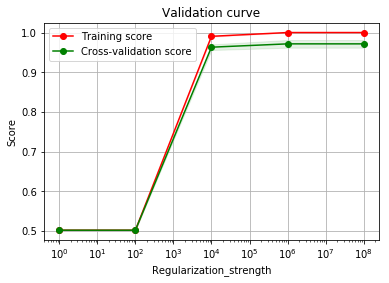

In [40]:
plt.figure()
plt.title('Validation curve')
plt.semilogx()
plt.xlabel('Regularization_strength')
plt.ylabel('Score')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.savefig('../docs/regularization_curve.png')
plt.show()

In [41]:
X.shape

(1192, 19829)

In [42]:
y.shape

(1192,)

In [43]:
svm_clf = SVC(C=1e6, kernel='rbf', gamma='auto', shrinking=True,
              tol=1e-3, probability=False)

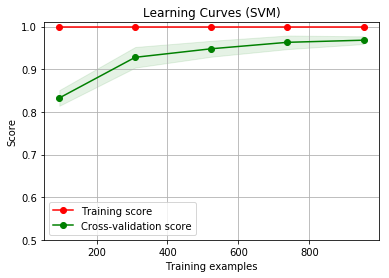

In [44]:
title = "Learning Curves (SVM)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
X, y = vectors, newsgroups_train.target
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(svm_clf, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.savefig('../docs/svm_learning_curve.png')

plt.show()

In [45]:
train_sizes, train_scores, test_scores = vocab_learning_curve(word_counts, svm_clf, LemmaTokenizer(), newsgroups_train, 4)

1000
1000
1000
1000
2000
2000
2000
2000
10000
10000
10000
10000
20000
20000
20000
20000
118548
118548
118548
118548


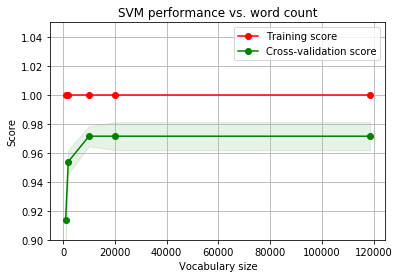

In [46]:
plt.figure()
plt.title('SVM performance vs. word count')
plt.ylim((0.9, 1.05))
plt.xlabel('Vocabulary size')
plt.ylabel('Score')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.savefig('../docs/svm_vocab_size.png')
plt.show()